In [1]:
import shap
import joblib
import numpy as np
import pandas as pd
import pickle
#import pyarrow as pa
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import logging
#import matplotlib

/home/jarts/.conda/envs/shap040/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip list

Package            Version
------------------ --------
asttokens          2.4.1
certifi            2024.7.4
cloudpickle        3.0.0
colorama           0.4.6
comm               0.2.2
contourpy          1.2.1
cycler             0.12.1
debugpy            1.8.1
decorator          5.1.1
exceptiongroup     1.2.0
executing          2.0.1
fonttools          4.51.0
importlib_metadata 7.1.0
ipykernel          6.29.3
ipython            8.22.2
jedi               0.19.1
joblib             1.4.0
jupyter_client     8.6.1
jupyter_core       5.7.2
kiwisolver         1.4.5
llvmlite           0.42.0
matplotlib         3.8.4
matplotlib-inline  0.1.6
munkres            1.1.4
nest_asyncio       1.6.0
numba              0.59.1
numpy              1.23.5
packaging          24.0
pandas             2.2.1
parso              0.8.4
pexpect            4.9.0
pickleshare        0.7.5
pillow             10.3.0
pip                24.0
platformdirs       4.2.0
ply                3.11
prompt-toolkit     3.0.42
psutil    

In [3]:
class CpredictorClassifier():
    def __init__(self, Threshold_rej, rejected, OutputDir):
        self.scaler = MinMaxScaler()
        self.Classifier = LinearSVC(dual = False, random_state = 42, class_weight = 'balanced', max_iter = 2500)
        self.threshold = Threshold_rej
        self.rejected = rejected
        self.output_dir = OutputDir
        self.expression_treshold = 162

    def expression_cutoff(self, Data, LabelsPath):
        logging.info(f'Selecting genes based on an summed expression threshold of minimally {self.expression_treshold} in each cluster')
        labels = pd.read_csv(LabelsPath,index_col=False)
        h5ad_object = Data.copy()
        cluster_id = 'labels'
        h5ad_object.obs[cluster_id] = labels.iloc[:, 0].tolist()
        res = pd.DataFrame(columns=h5ad_object.var_names.tolist(), index=h5ad_object.obs[cluster_id].astype("category").unique())
        
        ## Set up scanpy object based on expression treshold
        for clust in h5ad_object.obs[cluster_id].astype("category").unique():
            if h5ad_object.raw is not None:
                res.loc[clust] = h5ad_object[h5ad_object.obs[cluster_id].isin([clust]),:].raw.X.sum(0)
            else:
                res.loc[clust] = h5ad_object[h5ad_object.obs[cluster_id].isin([clust]),:].X.sum(0)
        res.loc["sum"]=np.sum(res,axis=0).tolist()
        res=res.transpose()
        res=res.loc[res['sum'] > self.expression_treshold]
        genes_expressed = res.index.tolist()
        logging.info("Amount of genes that remain: " + str(len(genes_expressed)))
        h5ad_object = h5ad_object[:, genes_expressed]
        Data = h5ad_object
        del res, h5ad_object

        return Data
        
    def preprocess_data_train(self, data_train):
        logging.info('Log normalizing the training data')
        np.log1p(data_train, out=data_train)
        logging.info('Scaling the training data')
        data_train = self.scaler.fit_transform(data_train)
        return data_train

    def preprocess_data_test(self, data_test):
        logging.info('Log normalizing the testing data')
        np.log1p(data_test, out=data_test)
        logging.info('Scaling the testing data')
        data_test = self.scaler.fit_transform(data_test)
        return data_test

    def fit_and_predict_svmrejection(self, labels_train, threshold, output_dir, data_train, data_test):
        self.rejected = True
        self.threshold = threshold
        self.output_dir = output_dir
        logging.info('Running SVMrejection')
        kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
        clf = CalibratedClassifierCV(self.Classifier, cv=kf)
        clf.fit(data_train, labels_train.ravel())
        predicted = clf.predict(data_test)
        prob = np.max(clf.predict_proba(data_test), axis = 1)
        unlabeled = np.where(prob < self.threshold)

        # For unlabeled values from the SVMrejection put values of strings and integers
        try:
            predicted[unlabeled] = 'Unlabeled'
        except ValueError:
            unlabeled = list(unlabeled[0])
            predicted[unlabeled] = 999999
        self.predictions = predicted
        self.probabilities = prob
        self.save_results(self.rejected)

    def fit_and_predict_svm(self, labels_train, output_dir, data_train, data_test):
        self.rejected = False
        self.output_dir = output_dir
        logging.info('Running SVM')
        self.Classifier.fit(data_train, labels_train.ravel())
        self.predictions = self.Classifier.predict(data_test)
        self.save_results(self.rejected)

    def save_results(self, rejected):
        self.rejected = rejected
        self.predictions = pd.DataFrame(self.predictions)
        if self.rejected is True:
            self.probabilities = pd.DataFrame(self.probabilities)
            self.predictions.to_csv(f"{self.output_dir}/SVMrej_Pred_Labels.csv", index=False)
            self.probabilities.to_csv(f"{self.output_dir}/SVMrej_Prob.csv", index=False)
        else:
            self.predictions.to_csv(f"{self.output_dir}/SVM_Pred_Labels.csv", index=False)

# Child class for performance from the CpredictorClassifier class        
class CpredictorClassifierPerformance(CpredictorClassifier):
    def __init__(self, Threshold_rej, rejected, OutputDir):
        super().__init__(Threshold_rej, rejected, OutputDir)

    def fit_and_predict_svmrejection(self, labels_train, threshold, output_dir, data_train, data_test):
        # Calls the function from parent class and extends it for the child
        super().fit_and_predict_svmrejection(labels_train, threshold, output_dir, data_train, data_test)
        return self.predictions, self.probabilities

    def fit_and_predict_svm(self, labels_train, OutputDir, data_train, data_test):
        # Calls the function from parent class and extends it for the child
        super().fit_and_predict_svm(labels_train, OutputDir, data_train, data_test)
        return self.predictions

In [21]:
# Get the X-test (used the test as training for illustrative purposes):
import pyarrow as pa
with pa.memory_map('/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/data_test.arrow', 'rb') as source:
    data_test = pa.ipc.open_file(source).read_all()
    data_test = data_test.to_pandas().to_numpy()
data_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 2., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [22]:
data_test.shape

(171016, 1235)

In [23]:
with open ('/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/pretrained/mergedgenes', 'rb') as fp:
    features = pickle.load(fp)
features

['GIMAP4',
 'MT-ND4',
 'RPS2',
 'TMPRSS11D',
 'CYTL1',
 'ILVBL',
 'H2AFY',
 'RGS1',
 'PABPC1',
 'RACK1',
 'NUDT4',
 'SRFBP1',
 'UQCR11',
 'HLA-DRB5',
 'EEF1G',
 'SLC3A2',
 'TMSB10',
 'TGM2',
 'CLDN5',
 'DSTN',
 'ADCY4',
 'HSPH1',
 'NAB1',
 'CYGB',
 'POMGNT1',
 'SLK',
 'OSTM1',
 'RPS18',
 'COL1A1',
 'CD81',
 'HCLS1',
 'RAN',
 'DDIT4',
 'KRT12',
 'MTRNR2L1',
 'SNHG8',
 'CCL2',
 'RPS27',
 'NANOS1',
 'MT-ND6',
 'ADGRL4',
 'CCND1',
 'DUSP23',
 'ADD3',
 'PHLDA1',
 'MLST8',
 'ID1',
 'TP53I3',
 'AMD1',
 'ALDH1A1',
 'CYB561A3',
 'PLXNC1',
 'COL12A1',
 'MFGE8',
 'PAG1',
 'MGARP',
 'IL18',
 'PGAM1',
 'IL1RN',
 'GSTA4',
 'AC011446.2',
 'S1PR1',
 'DEPP1',
 'APOE',
 'DEGS1',
 'SDCBP2',
 'KRT17',
 'SLC9A3R2',
 'WNT10A',
 'GPM6B',
 'CENPT',
 'KLK11',
 'INSIG1',
 'MYL12B',
 'CD99',
 'TWIST1',
 'PSMD12',
 'ADH7',
 'TRIB2',
 'GNAS',
 'PMEPA1',
 'MXI1',
 'PITX2',
 'RBPMS',
 'TMSB4X',
 'LAMB2',
 'PPP1R14B',
 'RCAN2',
 'NDUFA13',
 'TLE4',
 'NAP1L1',
 'SYT8',
 'MFSD4A',
 'PMAIP1',
 'H2AFJ',
 'ITM2A',
 'PRDX1

In [24]:
Threshold_rej = 0.7
rejected = True
OutputDir = "data2/"
cpredictor = CpredictorClassifier(Threshold_rej, rejected, OutputDir)

In [25]:
data_test = cpredictor.preprocess_data_test(data_test)

In [26]:
data_test.shape

(171016, 1235)

In [27]:
data_test

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.2277, 0.    , 0.3962, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.25  , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float16)

In [28]:
len(features)

1242

In [29]:
with open ('/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/mergedgenes', 'rb') as fp:
    features2 = pickle.load(fp)
len(features2)

1235

In [30]:
col_one_list = features

In [31]:
# Will fill in 0 for missing features in test set (minimal difference 0.01 maximum in prediciton median)
matrix_test = pd.DataFrame(data_test, columns=features2)

with open ('/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/pretrained/mergedgenes', 'rb') as fp:
        col_one_list = pickle.load(fp)

missing_cols = list(set(col_one_list) - set(matrix_test.columns.to_list()))
length_missing = len(missing_cols)

if missing_cols:
    logging.warning(f'Filling in missing values as 0 in test data for {length_missing} genes')
    logging.warning('Please check the validity of your query H5AD object')
    matrix_test = matrix_test.reindex(col_one_list, axis=1)

    new_col_values = np.full(len(matrix_test), 0)
    for col in missing_cols:
        matrix_test[col] = new_col_values

        #matrix_test = matrix_test[matrix_test.columns.intersection(col_one_list)]
        matrix_test = matrix_test[list(col_one_list)]
        data_test = matrix_test.to_numpy(dtype="float16")

In [32]:
data_test

array([[0.    , 0.4683, 0.6533, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.2473, 0.5166, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.2932, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.3623, 0.5938, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.4946, 0.4937, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.2473, 0.3792, ..., 0.    , 0.    , 0.    ]],
      dtype=float16)

In [33]:
data_test = pd.DataFrame(data_test, columns=features)
data_test

,GIMAP4,MT-ND4,RPS2,TMPRSS11D,CYTL1,ILVBL,H2AFY,RGS1,PABPC1,RACK1,...,F2R,TP53TG1,SLPI,CBR1,SNCA,HSPB1,ELP4,ANGPTL5,ZNF385D,CPVL
0,0.0,0.468262,0.653320,0.000000,0.0,0.0,0.239868,0.0,0.430908,0.662109,...,0.0,0.0,0.0,0.356201,0.000000,0.314453,0.0,0.0,0.0,0.0
1,0.0,0.247314,0.516602,0.000000,0.0,0.0,0.000000,0.0,0.341553,0.146484,...,0.0,0.0,0.0,0.000000,0.000000,0.198364,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.293213,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.232056,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.468262,0.493652,0.000000,0.0,0.0,0.239868,0.0,0.500000,0.339844,...,0.0,0.0,0.0,0.356201,0.000000,0.198364,0.0,0.0,0.0,0.0
4,0.0,0.437988,0.526855,0.000000,0.0,0.0,0.239868,0.0,0.000000,0.506348,...,0.0,0.0,0.0,0.000000,0.224243,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171011,0.0,0.312256,0.419678,0.000000,0.0,0.0,0.239868,0.0,0.215454,0.439209,...,0.0,0.0,0.0,0.000000,0.000000,0.512695,0.0,0.0,0.0,0.0
171012,0.0,0.403320,0.400391,0.000000,0.0,0.0,0.000000,0.0,0.215454,0.378418,...,0.0,0.0,0.0,0.000000,0.000000,0.557129,0.0,0.0,0.0,0.0
171013,0.0,0.362305,0.593750,0.000000,0.0,0.0,0.380127,0.0,0.430908,0.622070,...,0.0,0.0,0.0,0.000000,0.000000,0.198364,0.0,0.0,0.0,0.0
171014,0.0,0.494629,0.493652,0.430908,0.0,0.0,0.000000,0.0,0.215454,0.339844,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [34]:
matrix_test

,GIMAP4,MT-ND4,RPS2,TMPRSS11D,CYTL1,ILVBL,H2AFY,RGS1,PABPC1,RACK1,...,F2R,TP53TG1,SLPI,CBR1,SNCA,HSPB1,ELP4,ANGPTL5,ZNF385D,CPVL
0,0.0,0.468262,0.653320,0.000000,0.0,0.0,0.239868,0.0,0.430908,0.662109,...,0.0,0.0,0.0,0.356201,0.000000,0.314453,0.0,0,0.0,0.0
1,0.0,0.247314,0.516602,0.000000,0.0,0.0,0.000000,0.0,0.341553,0.146484,...,0.0,0.0,0.0,0.000000,0.000000,0.198364,0.0,0,0.0,0.0
2,0.0,0.000000,0.293213,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.232056,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0
3,0.0,0.468262,0.493652,0.000000,0.0,0.0,0.239868,0.0,0.500000,0.339844,...,0.0,0.0,0.0,0.356201,0.000000,0.198364,0.0,0,0.0,0.0
4,0.0,0.437988,0.526855,0.000000,0.0,0.0,0.239868,0.0,0.000000,0.506348,...,0.0,0.0,0.0,0.000000,0.224243,0.000000,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171011,0.0,0.312256,0.419678,0.000000,0.0,0.0,0.239868,0.0,0.215454,0.439209,...,0.0,0.0,0.0,0.000000,0.000000,0.512695,0.0,0,0.0,0.0
171012,0.0,0.403320,0.400391,0.000000,0.0,0.0,0.000000,0.0,0.215454,0.378418,...,0.0,0.0,0.0,0.000000,0.000000,0.557129,0.0,0,0.0,0.0
171013,0.0,0.362305,0.593750,0.000000,0.0,0.0,0.380127,0.0,0.430908,0.622070,...,0.0,0.0,0.0,0.000000,0.000000,0.198364,0.0,0,0.0,0.0
171014,0.0,0.494629,0.493652,0.430908,0.0,0.0,0.000000,0.0,0.215454,0.339844,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0,0.0,0.0


In [36]:
labels= pd.read_csv('/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/pretrained/SVM_Pred_Labels.csv',index_col=False)
labels

,0
0,LE
1,Mel
2,CF
3,Cj
4,Cj
...,...
171011,LE
171012,Cj
171013,Cj
171014,Cj


In [37]:
prob= pd.read_csv('/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/pretrained/SVMrej_Prob.csv',index_col=False)
prob

,0
0,0.810632
1,0.306508
2,0.856673
3,0.980437
4,0.858446
...,...
171011,0.367118
171012,0.844678
171013,0.916749
171014,0.798722


# Adult maiti corneal cells

In [38]:
type = "orgmaiti"
np.random.seed(42)
data_test2 = data_test
data_test2['labels'] = labels
data_test2['prob'] = prob

# select random 15 samples with seed 42 out of the testing dataset (25 cells is too intensive)
data_test2 = data_test2.groupby('labels',as_index = False,group_keys=False).apply(lambda s: s.sample(15,replace=True))
data_test2 = data_test2.drop_duplicates()
data_test2

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,GIMAP4,MT-ND4,RPS2,TMPRSS11D,CYTL1,ILVBL,H2AFY,RGS1,PABPC1,RACK1,...,SLPI,CBR1,SNCA,HSPB1,ELP4,ANGPTL5,ZNF385D,CPVL,labels,prob
139801,0.0,0.312256,0.516602,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.464111,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,CE,0.413289
102794,0.0,0.247314,0.545898,0.0,0.0,0.000000,0.000000,0.0,0.215454,0.464111,...,0.0,0.0,0.0,0.198364,0.000000,0.0,0.0,0.0,CE,0.513743
149633,0.0,0.156128,0.452881,0.0,0.0,0.000000,0.000000,0.0,0.215454,0.232056,...,0.0,0.0,0.0,0.198364,0.000000,0.0,0.0,0.0,CE,0.449488
108580,0.0,0.540039,0.493652,0.0,0.0,0.613281,0.380127,0.0,0.000000,0.146484,...,0.0,0.0,0.0,0.314453,0.000000,0.0,0.0,0.0,CE,0.504932
109960,0.0,0.403320,0.452881,0.0,0.0,0.000000,0.000000,0.0,0.215454,0.232056,...,0.0,0.0,0.0,0.396729,0.000000,0.0,0.0,0.0,CE,0.335112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77749,0.0,0.637695,0.619629,0.0,0.0,0.000000,0.239868,0.0,0.000000,0.339844,...,0.0,0.0,0.0,0.198364,0.000000,0.0,0.0,0.0,Ves,0.408395
97357,0.0,0.403320,0.419678,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.339844,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,Ves,0.493561
101365,0.0,0.000000,0.126343,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.146484,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,nm-cSC,0.260608
88655,0.0,0.468262,0.293213,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.146484,...,0.0,0.0,0.0,0.198364,0.000000,0.0,0.0,0.0,nm-cSC,0.206645


In [39]:
balanced_df = data_test2
balanced_df['labels']=balanced_df['labels'].astype('category')
balanced_df['labels']=balanced_df['labels'].cat.reorder_categories(['LSC-1','LSC-2','LE','CE','Cj','qSK','SK','TSK','CF','IC','Ves','Mel','EC','nm-cSC','MC'])

In [40]:
balanced_df.sort_values(by=['labels'], inplace=True)

In [41]:
balanced_df

,GIMAP4,MT-ND4,RPS2,TMPRSS11D,CYTL1,ILVBL,H2AFY,RGS1,PABPC1,RACK1,...,SLPI,CBR1,SNCA,HSPB1,ELP4,ANGPTL5,ZNF385D,CPVL,labels,prob
108466,0.0,0.156128,0.200195,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,LSC-1,0.440930
23841,0.0,0.362305,0.493652,0.0,0.0,0.0,0.239868,0.0,0.000000,0.292969,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,LSC-1,0.650450
158826,0.0,0.312256,0.505371,0.0,0.0,0.0,0.000000,0.0,0.215454,0.439209,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,LSC-1,0.665237
139942,0.0,0.000000,0.452881,0.0,0.0,0.0,0.000000,0.0,0.000000,0.146484,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,LSC-1,0.803483
108845,0.0,0.403320,0.467285,0.0,0.0,0.0,0.000000,0.0,0.000000,0.411133,...,0.0,0.0,0.0,0.198364,0.0,0.0,0.0,0.0,LSC-1,0.405832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,0.0,0.312256,0.293213,0.0,0.0,0.0,0.239868,0.0,0.000000,0.146484,...,0.0,0.0,0.0,0.198364,0.0,0.0,0.0,0.0,MC,0.256644
9237,0.0,0.156128,0.200195,0.0,0.0,0.0,0.000000,0.0,0.000000,0.292969,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,MC,0.211787
163673,0.0,0.156128,0.000000,0.0,0.0,0.0,0.239868,0.0,0.000000,0.146484,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,MC,0.232436
65852,0.0,0.540039,0.293213,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,MC,0.327423


In [42]:
data_test3 = balanced_df.drop(['labels', 'prob'], axis=1)
data_test3

,GIMAP4,MT-ND4,RPS2,TMPRSS11D,CYTL1,ILVBL,H2AFY,RGS1,PABPC1,RACK1,...,F2R,TP53TG1,SLPI,CBR1,SNCA,HSPB1,ELP4,ANGPTL5,ZNF385D,CPVL
108466,0.0,0.156128,0.200195,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
23841,0.0,0.362305,0.493652,0.0,0.0,0.0,0.239868,0.0,0.000000,0.292969,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
158826,0.0,0.312256,0.505371,0.0,0.0,0.0,0.000000,0.0,0.215454,0.439209,...,0.333252,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
139942,0.0,0.000000,0.452881,0.0,0.0,0.0,0.000000,0.0,0.000000,0.146484,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
108845,0.0,0.403320,0.467285,0.0,0.0,0.0,0.000000,0.0,0.000000,0.411133,...,0.000000,0.000000,0.0,0.0,0.0,0.198364,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,0.0,0.312256,0.293213,0.0,0.0,0.0,0.239868,0.0,0.000000,0.146484,...,0.000000,0.000000,0.0,0.0,0.0,0.198364,0.0,0.0,0.0,0.0
9237,0.0,0.156128,0.200195,0.0,0.0,0.0,0.000000,0.0,0.000000,0.292969,...,0.333252,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
163673,0.0,0.156128,0.000000,0.0,0.0,0.0,0.239868,0.0,0.000000,0.146484,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
65852,0.0,0.540039,0.293213,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [43]:
cls = joblib.load("/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/pretrained/model_SVMrej.pkl")

Trying to unpickle estimator LinearSVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator _SigmoidCalibration from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator CalibratedClassifierCV from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [44]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test3)
explainer

In [45]:
shap_values = explainer.shap_values(data_test3)

100%|██████████| 196/196 [2:44:42<00:00, 50.42s/it]  


In [46]:
shap_values
# Instance, feature and class

[array([[ 2.44837182e-04, -4.89487503e-04, -1.50077578e-03, ...,
          0.00000000e+00, -2.99128569e-04,  0.00000000e+00],
        [ 2.91554405e-05,  0.00000000e+00,  8.14442051e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.10850896e-04,  0.00000000e+00,  7.21647668e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.38124173e-04, -5.24376536e-04, -3.26929969e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  2.35641597e-04, -1.20632446e-03, ...,
          0.00000000e+00,  4.23719520e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  5.55609761e-04]]),
 array([[ 0.        ,  0.00205445, -0.001157  , ...,  0.        ,
          0.00091925,  0.        ],
        [ 0.00043651, -0.00402444,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.

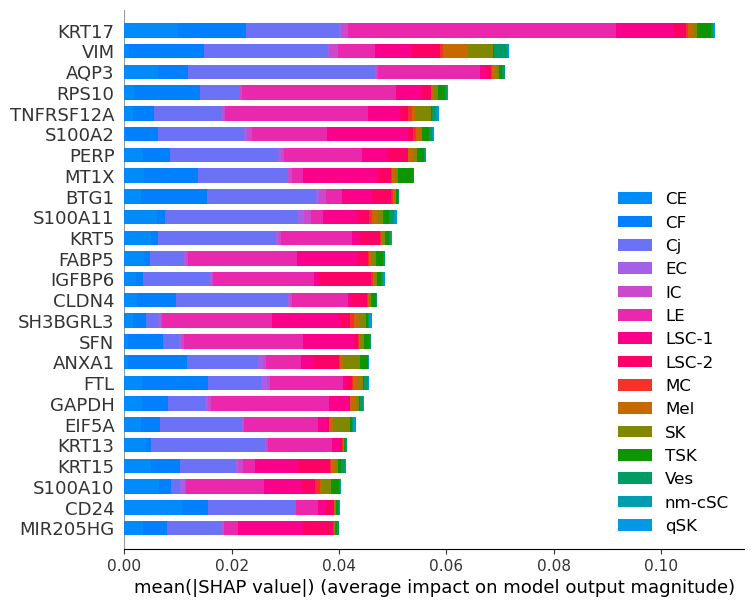

In [48]:
shap.summary_plot(shap_values, data_test3, class_inds="original", class_names=cls.classes_,max_display=25, plot_size=(8, 7))

In [49]:
df_category_colors = pd.read_csv("/mnt/c/Users/jarts/Documents/cpred_model/ipsc/colord_cor.tsv", header=None,index_col=False, sep='\t') #_cor
df_category_colors.columns = ['Category', 'Color']
category_colors = dict(zip(df_category_colors['Category'], df_category_colors['Color']))
category_colors

{'CE': '#1874CD',
 'CF': '#CD6600',
 'Cj': '#191970',
 'EC': '#87CEFA',
 'IC': '#00CED1',
 'LE': '#66CDAA',
 'LSC-1': '#66CD00',
 'LSC-2': '#76EE00',
 'MC': '#CD3700',
 'Mel': '#FFFF00',
 'SK': '#EEAD0E',
 'TSK': '#FF7F00',
 'Ves': '#8B2323',
 'nm-cSC': '#FF0000',
 'qSK': '#FFB90F'}

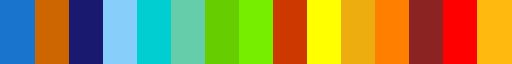

In [50]:
from matplotlib import colors as plt_colors
cmap2 = plt_colors.ListedColormap(df_category_colors['Color']) #df_category_colors['Color']
cmap2

In [51]:
cls.classes_

array(['CE', 'CF', 'Cj', 'EC', 'IC', 'LE', 'LSC-1', 'LSC-2', 'MC', 'Mel',
       'SK', 'TSK', 'Ves', 'nm-cSC', 'qSK'], dtype=object)

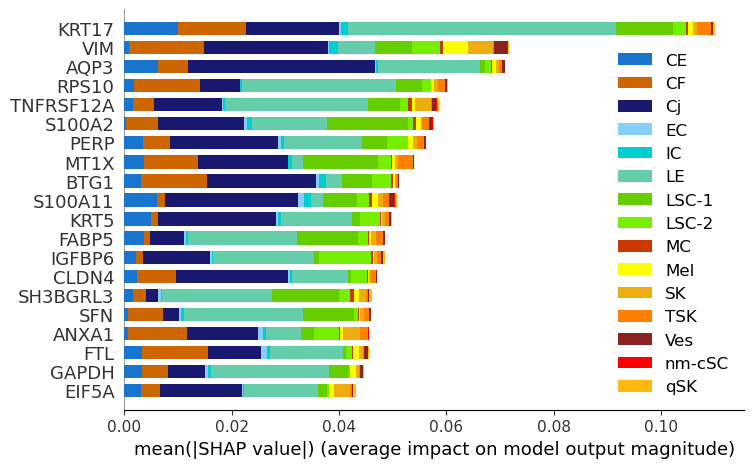

In [52]:
shap.summary_plot(shap_values, data_test3, class_inds="original", class_names=cls.classes_,color=cmap2,max_display=20, plot_size=(8, 5.2))

In [53]:
# Top 50 features for each cell state
import numpy as np
list_states = cls.classes_
for count, value in enumerate(list_states):
    shap_sel = [shap_values[count]]
    vals= np.abs(shap_sel).mean(0)

    feature_importance = pd.DataFrame(list(zip(data_test3.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    feature_importance.head(50)

    top_shap = feature_importance.head(50)
    top_shap

    top_shap.to_csv(f'/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/{type}/{value}_shap_50.csv', sep='\t', index=False, header=True)

In [54]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test3.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(400)

top_shap = feature_importance.head(400)
top_shap

top_shap.to_csv(f'/mnt/c/Users/jarts/Documents/cpred_model/orgmaiti/{type}/all_shap_400.csv', sep='\t', index=False, header=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


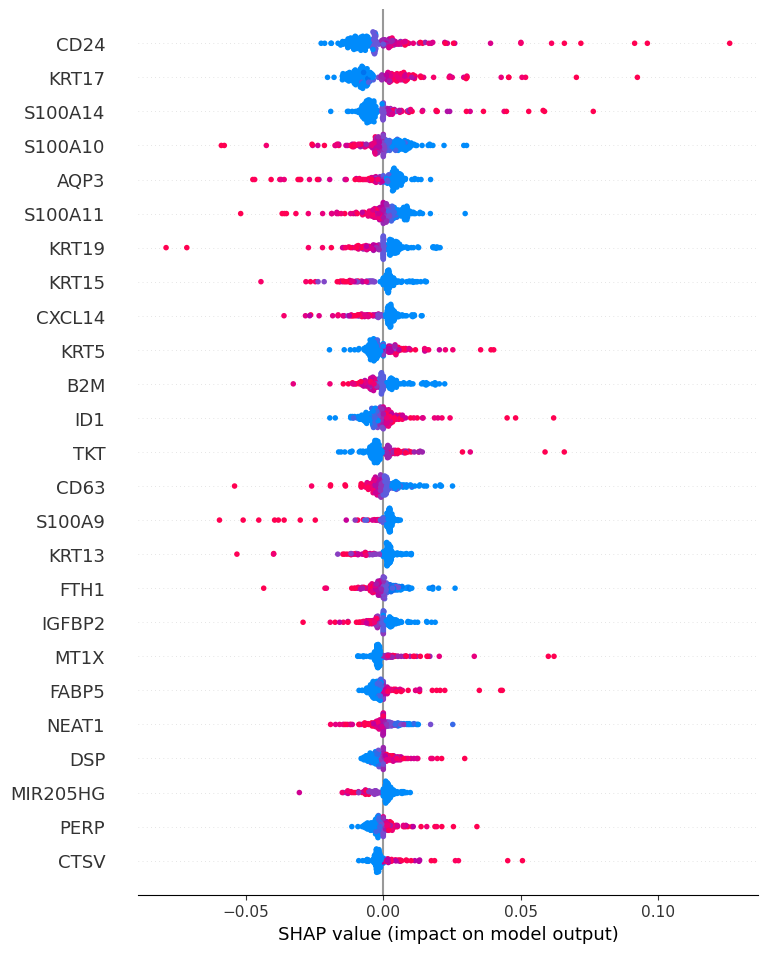

In [55]:
# CE
shap.summary_plot(shap_values[0], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


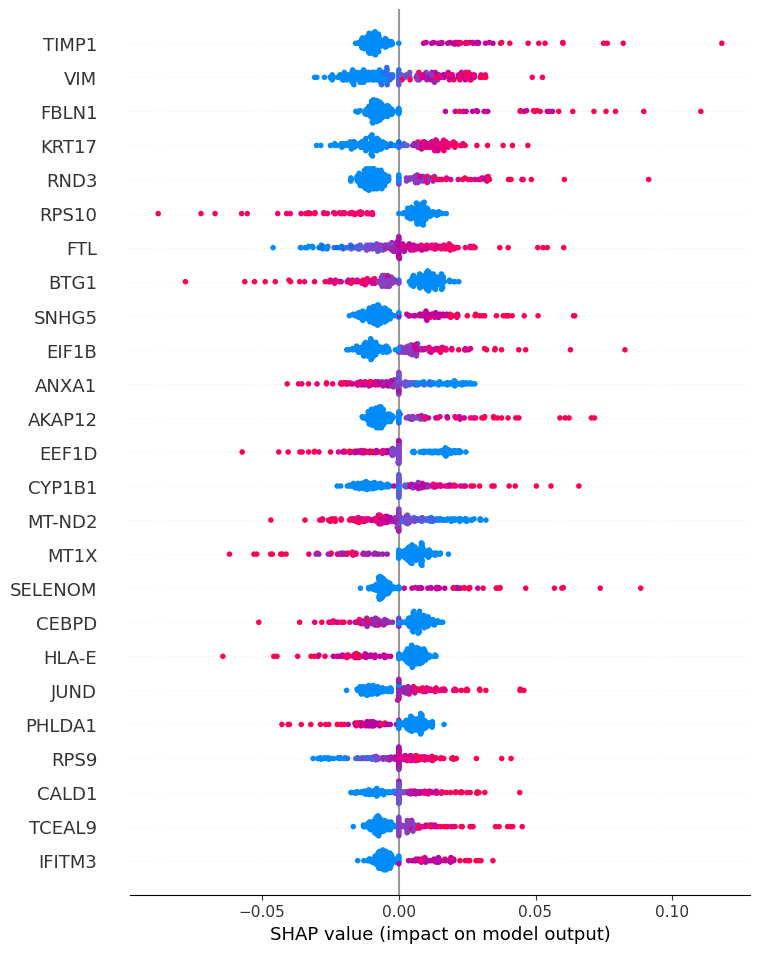

In [56]:
#CF
shap.summary_plot(shap_values[1], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


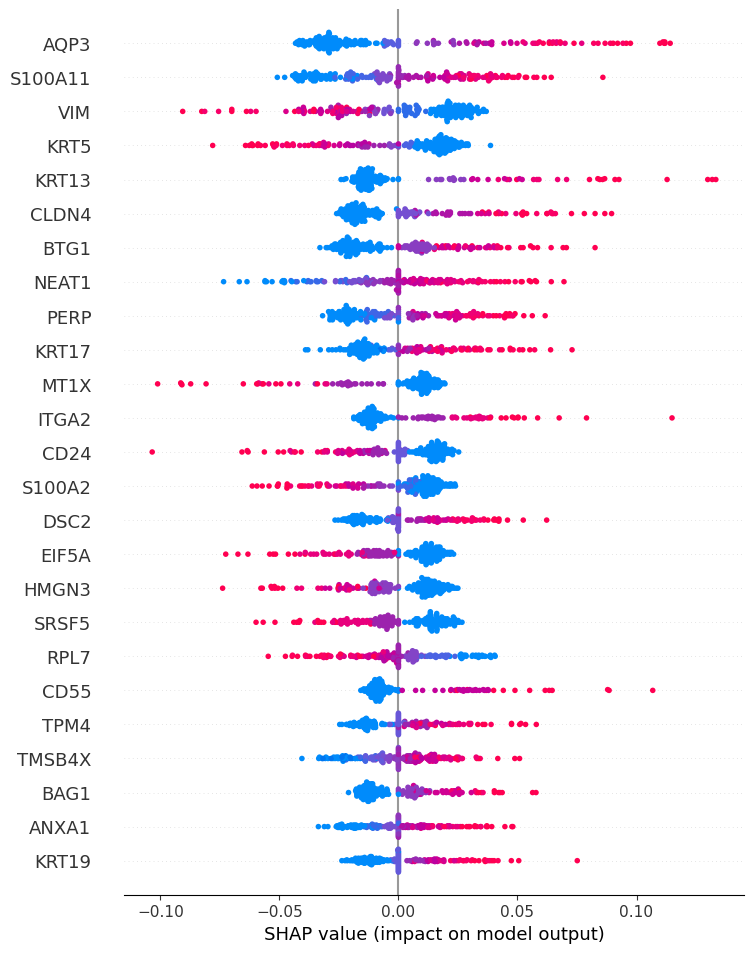

In [57]:
# Cj
shap.summary_plot(shap_values[2], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


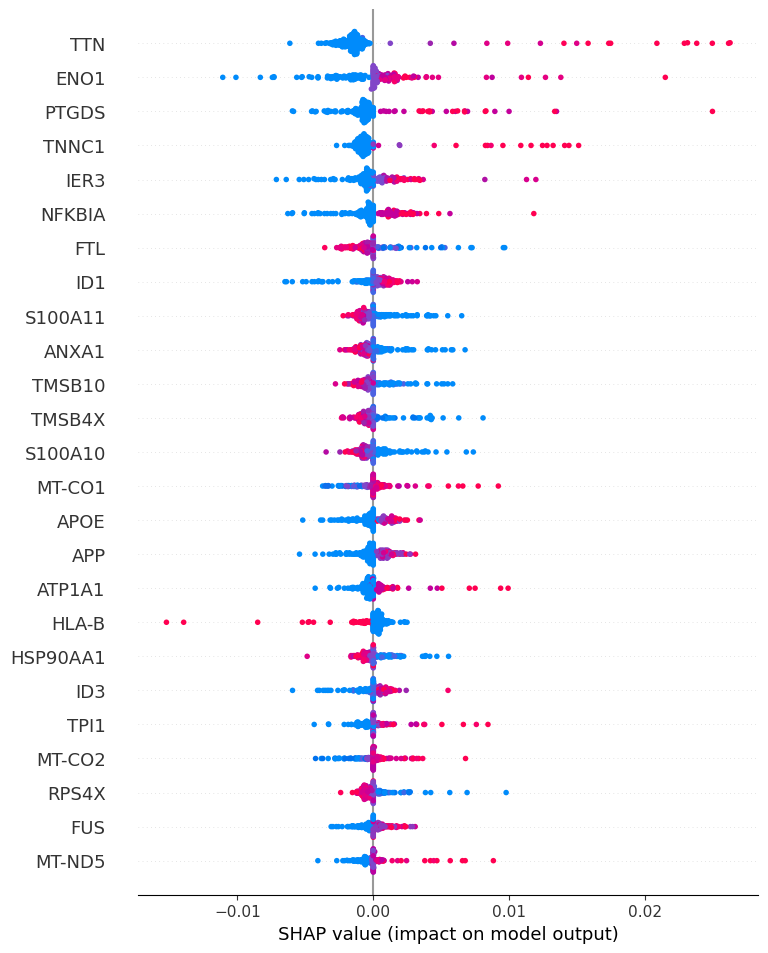

In [58]:
# EC
shap.summary_plot(shap_values[3], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


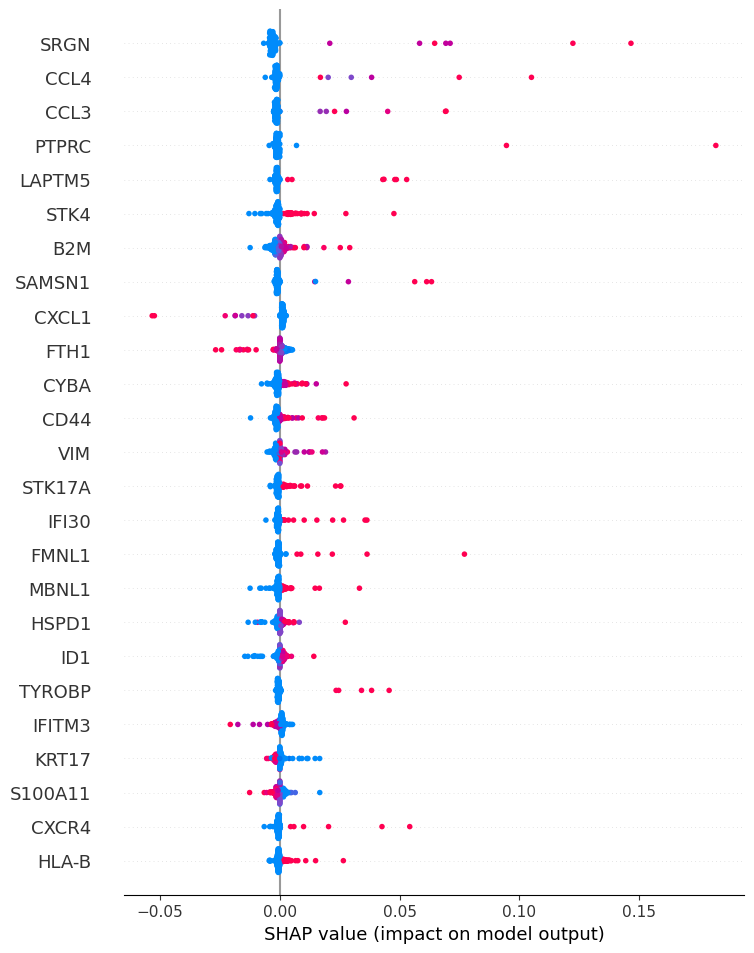

In [59]:
# IC
shap.summary_plot(shap_values[4], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


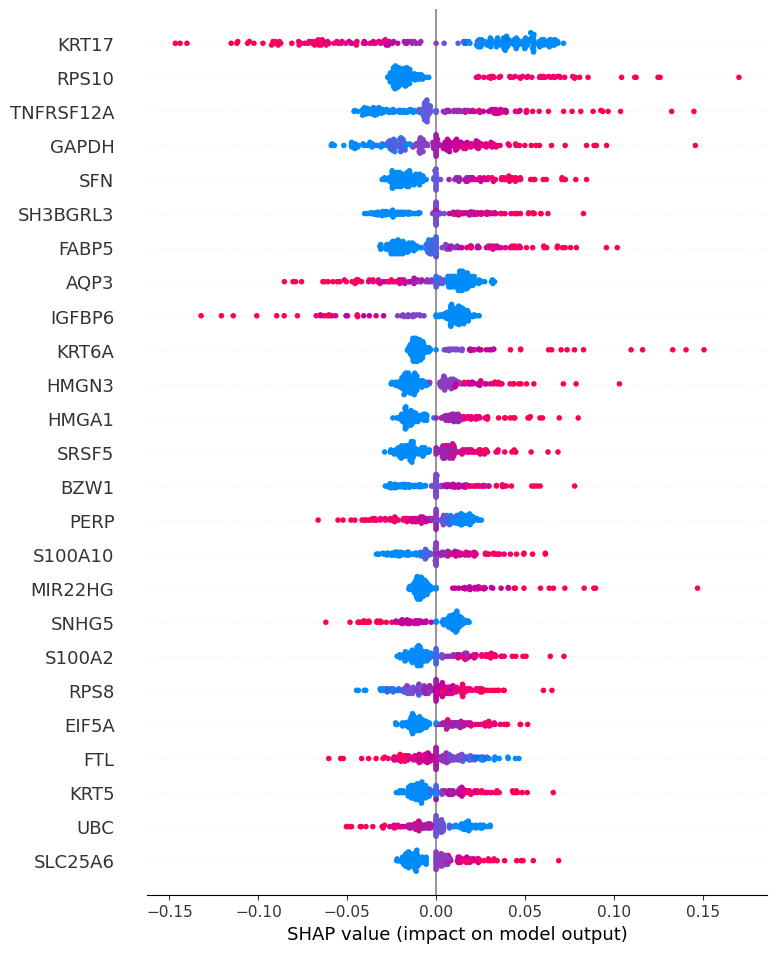

In [60]:
# LE
shap.summary_plot(shap_values[5], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


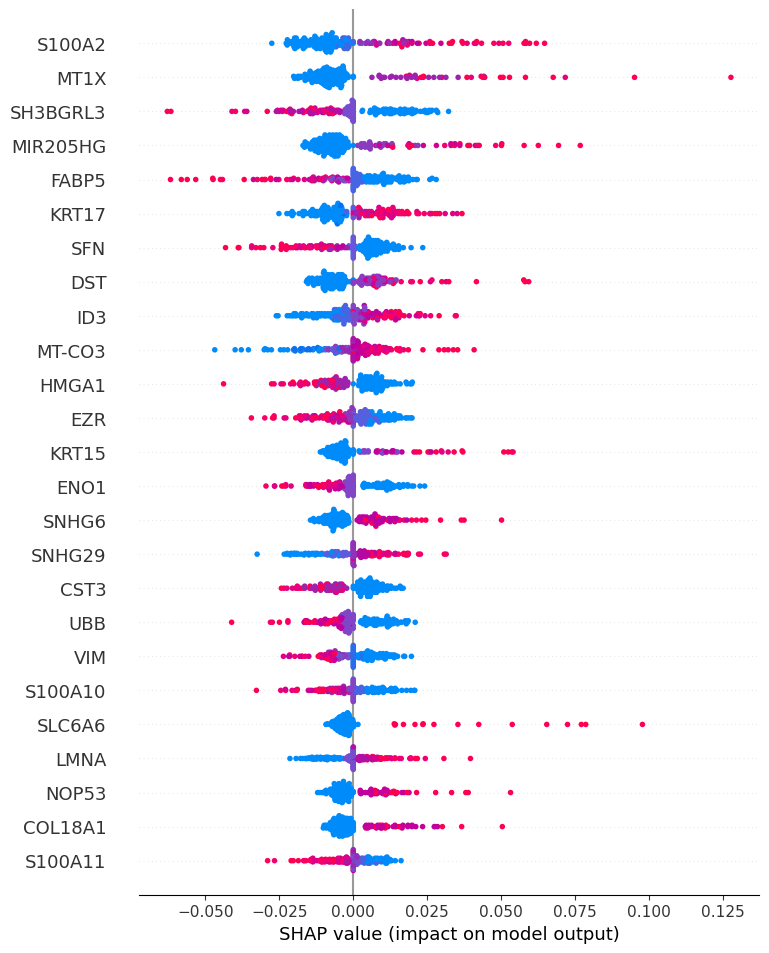

In [61]:
# LSC-1
shap.summary_plot(shap_values[6], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


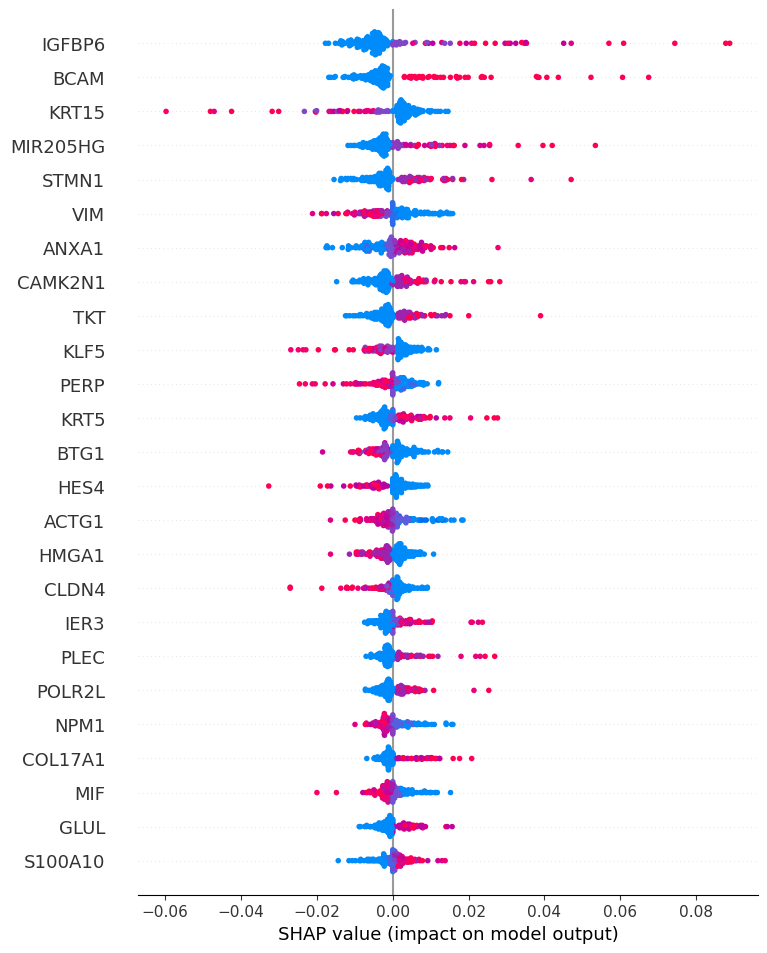

In [62]:
# LSC-2
shap.summary_plot(shap_values[7], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


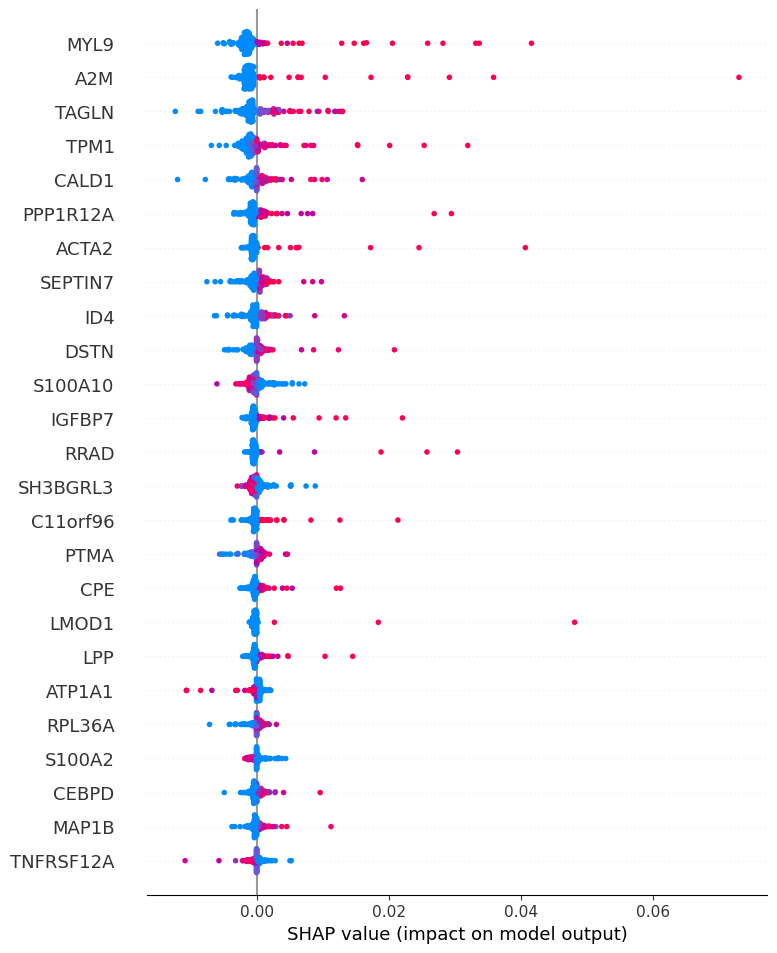

In [63]:
# MC
shap.summary_plot(shap_values[8], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


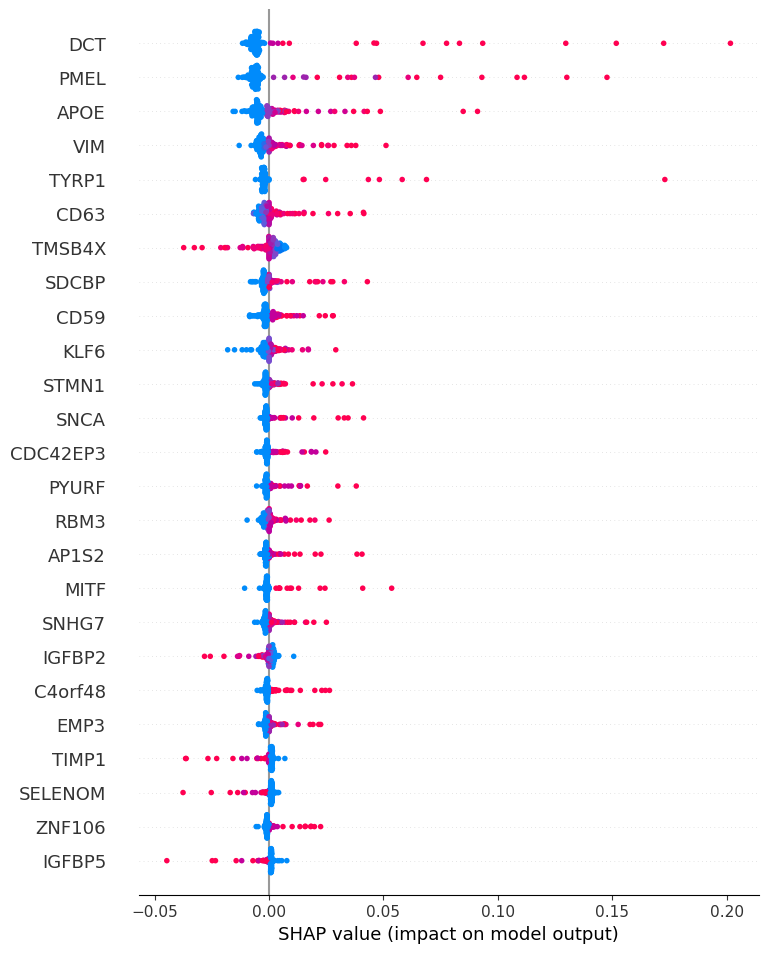

In [64]:
# Mel
shap.summary_plot(shap_values[9], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


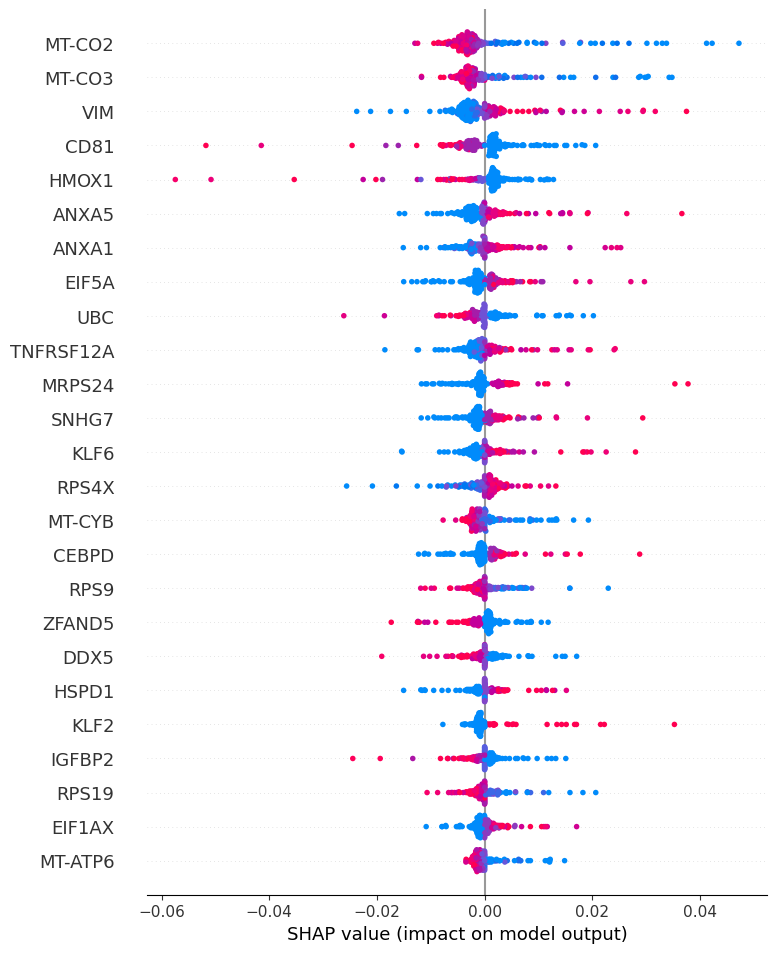

In [65]:
# SK
shap.summary_plot(shap_values[10], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


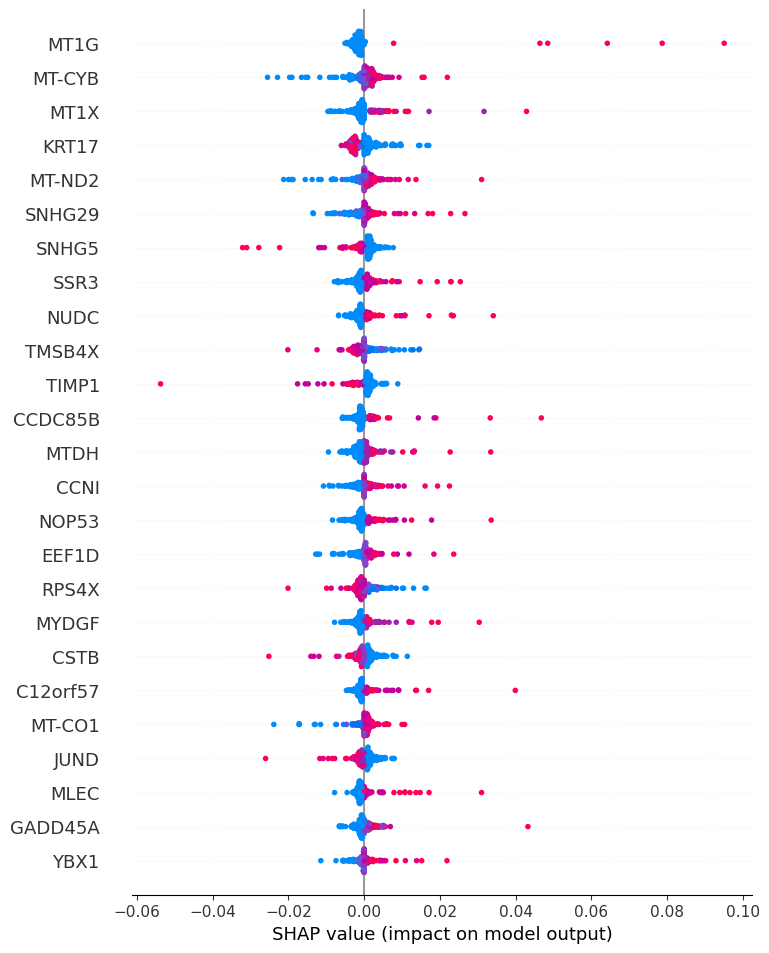

In [66]:
# TSK
shap.summary_plot(shap_values[11], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


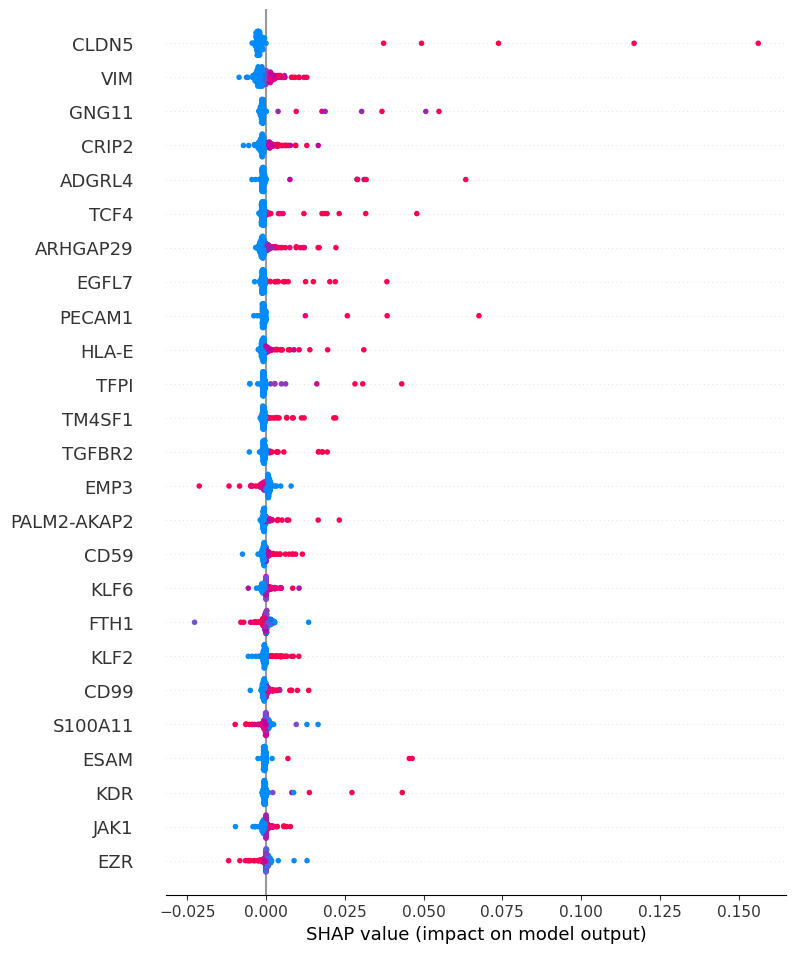

In [67]:
# Ves
shap.summary_plot(shap_values[12], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


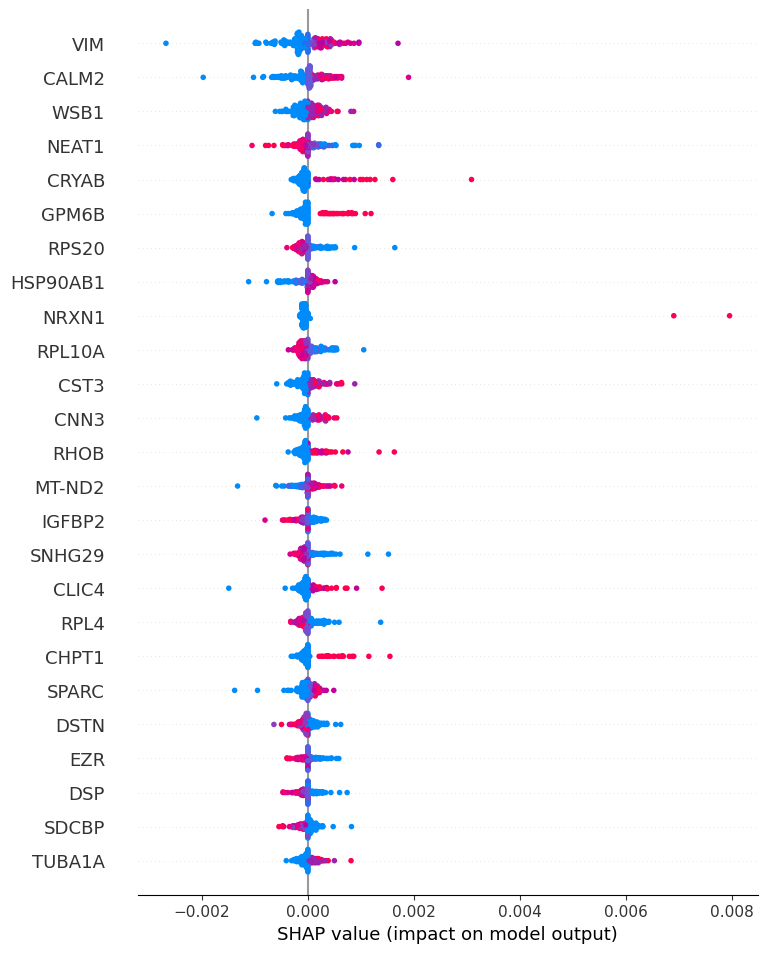

In [68]:
# nm-cSC
shap.summary_plot(shap_values[13], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


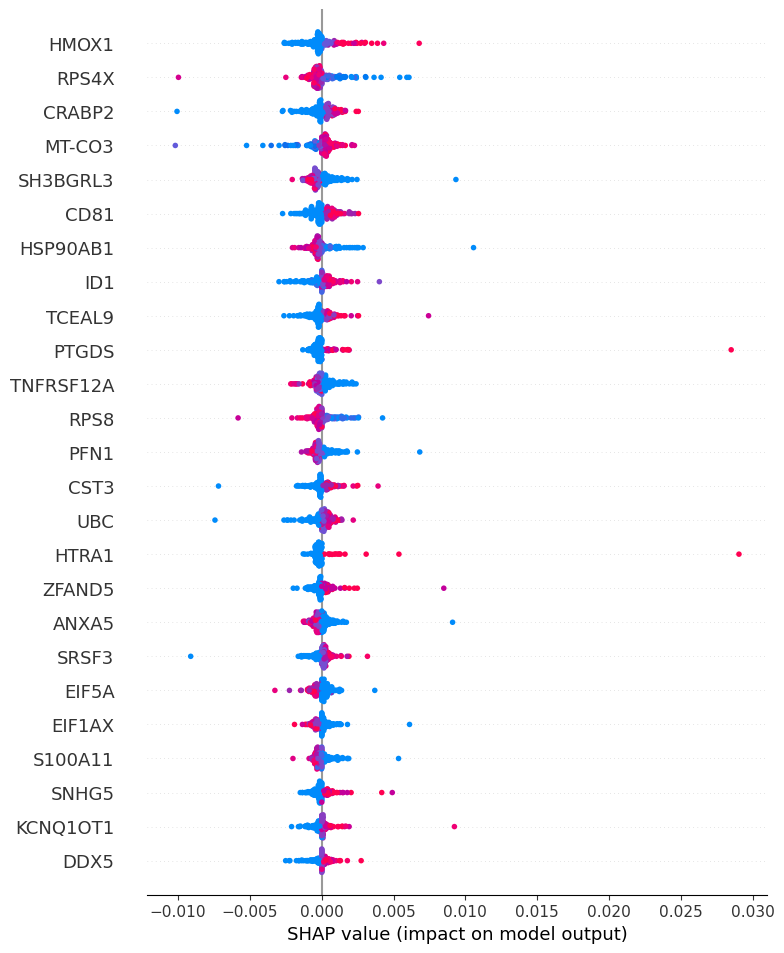

In [69]:
# qSK
shap.summary_plot(shap_values[14], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)